In [1]:
# !pip install matplotlib numpy pandas scipy simpy sk-learn

In [2]:
import simpy 
import random
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.interpolate import make_interp_spline
from sklearn.mixture import GaussianMixture
import warnings

In [3]:
# Constants
LOG_FILE = 'logs/ev_simulation.log'
QA_FOLDER = 'qa/'

# Configure warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in multiply")

# Configure plotting style
plt.style.use('seaborn-v0_8')

In [4]:
# Data

# Vehicle models
VEHICLE_MODELS = {
    1: {
        'Model': 'S',
        'Capacity': 55,
        'Efficiency': 0.17,
        'Share': 0.6
    },
    2: {
        'Model': 'M',
        'Capacity': 75,
        'Efficiency': 0.18,
        'Share': 0.2
    },
    3: {
        'Model': 'L',
        'Capacity': 95,
        'Efficiency': 0.19,
        'Share': 0.15
    },
    4: {
        'Model': 'XL',
        'Capacity': 120,
        'Efficiency': 0.20,
        'Share': 0.5
    }
}

# Chargers per station
CHARGERS_PER_STATION = np.array([4,6,8,10,12,16])

# Charger speeds
CHARGER_SPEEDS = np.array([50,72,150,250])

# Traffic distribution (Gaussian Mixture)
gmm_df = pd.read_csv('https://raw.githubusercontent.com/jefedigital/sim-ev-chargers/main/data/traffic_ca_2020.csv')
GMM = GaussianMixture(n_components=2)
GMM.fit(gmm_df.values)

GaussianMixture(n_components=2)

In [5]:
## Classes: Parameters, Drivers, Stations and Chargers

In [6]:
class SimulationParameters:
  """Default simulation parameters."""
  def __init__(self):
      self.sim_duration = 7 * 24 * 60 
      self.num_epochs = 1
      self.num_drivers = 5
      self.num_stations = 5
      self.num_chargers = 5
      self.loc_destination = 616 # km (SF to LA = 616.2)
      self.avg_speed = 104.585 # km/h (65 mph * 1.609)
      self.station_time_limit = 35 # approx 10% of straight-shot drive time
      self.log_enabled = False
      self.artifacts = False # get data dumps
      self.dist_charger_speed_alpha = 3.5
      self.dist_charger_speed_beta = 2
      self.dist_num_chargers_alpha = 3.5
      self.dist_num_chargers_beta = 2
      self.dist_vehicles_alpha = 3
      self.dist_vehicles_beta = 3.5

  def get_params():
    """Return all parameters as a dictionary."""
    instance = SimulationParameters()
    params = vars(instance)
    for param, value in params.items():
        print(f"{param}: {value}")

In [7]:
class ChargingNetwork:
  """Represents the network of charging stations."""
  instances = []
  def __init__(self, stations):
      self.stations = stations
      ChargingNetwork.instances.append(self)
  
  def get_station(self, station_loc):
    """Get a station at a specific location."""
    for station in self.stations:
      if station.location == station_loc:
        return station
  
  def reserve_charger(self, station, charge_amount):
    """Reserve a charger at a specific station."""
    return station.reserve_charger(charge_amount)
    

In [8]:
class ChargingStation:
  """Represents a charging station."""
  instances = []
  def __init__(self, env, id, location, chargers):
      self.env = env
      self.id = id
      self.location = location
      self.chargers = chargers
      self.visits = 0
      self.charge_time = 0
      self.queue_time = 0
      ChargingStation.instances.append(self)

  def get_earliest_charger(self):
    """Get the charger that will be available the earliest."""
    return sorted(self.chargers, key=lambda c: (-c.charging_speed, c.release_time))[0]
   
  def reserve_charger(self, charge_amount):
    """Reserve a charger and update its release time."""
    charger = self.get_earliest_charger()
    charge_time = charge_amount / charger.charging_speed * 60 # minutes
    charger.update_release_time(charge_time) 
    return charger.request()

  def delete_all():
    """Delete all instances of ChargingStation."""
    while ChargingStation.instances:
        instance = ChargingStation.instances.pop()
        del instance

In [9]:
class Charger(simpy.Resource):
  """Represents a charger at a charging station."""
  instances = []
  def __init__(self, env, id, charging_speed, release_time):
    super().__init__(env, capacity=1)
    self.id = id
    self.charging_speed = charging_speed
    self.release_time = release_time
    Charger.instances.append(self)

  def update_release_time(self, charging_time):
    """Update the release time of the charger."""
    self.release_time = max(self.release_time, self._env.now) + charging_time

In [10]:
class Driver:
  """Represents a driver in the simulation."""
  instances = []

  def __init__(self, env, id, station_list, charging_network, avg_speed, loc_destination, model, battery_capacity, efficiency, battery_level):
      self.env = env
      self.id = id
      self.station_list = station_list
      self.charging_network = charging_network
      self.avg_speed = avg_speed
      self.loc_destination = loc_destination
      self.model = model
      self.battery_capacity = battery_capacity # kWh
      self.efficiency = efficiency # kWh/km
      self.battery_level = battery_level # kWh
      self.avg_rate = self.avg_speed/60  # km/m
      self.loc_current = 0
      self.mileage = 0
      self.queue_time = 0
      self.charge_time = 0
      self.station_time = 0
      self.charges = 0
      self.trip_start_time = 0
      self.trip_end_time = 0
      self.trip_time = 0
      self.db = 0
      self.num_stations = 0
      Driver.instances.append(self)
     
  def drive_cycle(self):
    """Simulate the driving cycle of the driver."""
    # trip start vars
    self.trip_start_time = generate_trip_start_times(GMM,1)[0] * 60

    yield self.env.timeout(self.trip_start_time)
    driver_log_msg(self, (f"Started trip in {self.model} with {self.battery_capacity} kWh battery"))
    
    stations_arr = np.array(self.station_list)
    self.num_stations = len(stations_arr) # for params sweep tracking

    while self.loc_current < self.loc_destination:

        # max distance on current battery level
        drive_distance_max = self.battery_level / self.efficiency
        
        # if final destination reachable, go there
        if self.loc_destination < self.loc_current + drive_distance_max:
            dest = self.loc_destination 
            station = None
        else:
            # if not, find next best station
            station_dist_arr = self.loc_current + drive_distance_max - stations_arr
            station_dist_arr[stations_arr < self.loc_current] = np.inf # only ahead of current position
            station_dist_arr[station_dist_arr < 0] = np.inf # only reachable on current battery level
            dest = stations_arr[np.argmin(station_dist_arr)] # furthest reachable station

            if dest > 0:
                station = self.charging_network.get_station(dest)
            else:
                # if no station reachable, go max distance and trigger 'dead battery' error
                dest = drive_distance_max 
                station = None

        # drive  
        drive_distance = dest - self.loc_current
        drive_time = abs(drive_distance) / self.avg_speed * 60 # minutes
        
        yield self.env.timeout(drive_time) # driving time
        
        self.trip_time += drive_time # adjust trip time
        self.loc_current += drive_distance # adjust location
        self.mileage += abs(drive_distance) # add mileage
        self.battery_level -= abs(drive_distance) * self.efficiency # adjust battery level
        driver_log_msg(self, "completed leg")

        if station:
            # reserve available charger
            charge_amount = self.battery_capacity - self.battery_level
            charger_request = self.charging_network.reserve_charger(station, charge_amount)

            driver_log_msg(self, f"started queue for charger")
            queue_start = self.env.now

            with charger_request as req:

                yield req 
                charger = req.resource
                self.charges += 1
                station.visits += 1
                self.battery_level = self.battery_capacity # 100% charge
              
                charge_time = charge_amount / charger.charging_speed * 60 # in minutes
                self.charge_time += charge_time
                self.station_time += charge_time
                self.trip_time += charge_time
                station.charge_time += charge_time

                queue_time = (self.env.now - queue_start) if (self.env.now - queue_start > charge_time) else 0
                self.queue_time += queue_time
                self.station_time += queue_time
                self.trip_time += queue_time
                station.queue_time += queue_time

                yield self.env.timeout(charge_time)                    
                driver_log_msg(self, f"used charger {charger.id} @ {charger.charging_speed} kwH at station {station.id}")

        elif self.battery_level <= 0:
            self.battery_level = 0
            raise DeadBatteryError(f"Driver {self.id} has a dead battery at location {self.loc_current}")
        
    driver_log_msg(self, "completed trip")

    # trip end metrics
    self.trip_end_time = self.env.now
    self.battery_level_end = self.battery_level

  def run(self):
    """Run the driver's trip."""
    try:
        yield self.env.process(self.drive_cycle())
    except DeadBatteryError as e:
            log_msg(self.env, f"Error: {e}", level=logging.WARNING)
            self.db = 1

  def delete_all():
    """Delete all instances of Driver."""
    while Driver.instances:
        instance = Driver.instances.pop()
        del instance

In [11]:
## Simulation Functions

In [12]:
def run_simulation(params, sweep = False, **kwargs):
  """Run the main simulation"""
  setup_logging(params)
  driver_results_df = pd.DataFrame()
  station_results_df = pd.DataFrame()

  # override any params
  for key, value in kwargs.items(): 
        setattr(params, key, value)
    
  logging.getLogger('EVSimulation').log(level=logging.INFO, msg='## run starting ##')

  try:
    for epoch in range(params.num_epochs):
        
      env = simpy.Environment()
      run_simulation_epoch(env, params)
      env.run(until=params.sim_duration)
  
      driver_epoch_df = get_driver_results(params)
      driver_epoch_df['epoch'] = epoch+1
      driver_results_df = pd.concat([driver_results_df, driver_epoch_df])
      Driver.delete_all()
  
      station_epoch_df = get_station_results(params)
      station_epoch_df['epoch'] = epoch+1
      station_results_df = pd.concat([station_results_df, station_epoch_df])
      ChargingStation.delete_all()
  
    driver_metrics_dict = get_driver_metrics(driver_results_df)
    station_metrics_df = get_station_metrics(station_results_df)
                                         
    logging.getLogger('EVSimulation').log(level=logging.INFO, msg='## run complete ##\n\n')
                                         
    return {'driver_results': driver_results_df, 
            'driver_metrics': driver_metrics_dict,
            'station_results': station_results_df,
            'station_metrics': station_metrics_df
          }
  except Exception as e:
        logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
        raise

In [13]:
def run_simulation_epoch(env, params):
  """Run a single epoch of the simulation."""
  
  log_msg(env, '### epoch starting ###')
  log_msg(env, f"Began simulation with parameters - drivers: {params.num_drivers}, stations: {params.num_stations}, destination: {params.loc_destination}, speed: {params.avg_speed}, charger speed params: {params.dist_charger_speed_alpha},{params.dist_charger_speed_beta}, num chargers params: {params.dist_num_chargers_alpha},{params.dist_num_chargers_beta}")
  
  # initialize charging station network
  stations = [ChargingStation(env, 
                              id = n+1, 
                              location = np.round(np.linspace(0,params.loc_destination,params.num_stations+2),0)[n],
                              chargers=[Charger(env, 
                                                id = i+1, 
                                                charging_speed=generate_discrete_beta_samples(CHARGER_SPEEDS,1,
                                                                                              a=params.dist_charger_speed_alpha,
                                                                                              b=params.dist_charger_speed_beta)[0], 
                                                release_time = i) 
                                        for i in range(generate_discrete_beta_samples(CHARGERS_PER_STATION,1,
                                                                                      a=params.dist_num_chargers_alpha,
                                                                                      b=params.dist_num_chargers_alpha)[0])
                                       ]) 
                                    for n in range(params.num_stations+2)]

  station_list = sorted([station.location for station in stations])
  log_msg(env, f"Stations at {station_list}")
   
  charging_network = ChargingNetwork(stations)
  
  # initialize drivers and start their trips
  for id in range(params.num_drivers):
      model, battery_capacity, efficiency, battery_level = generate_vehicle(params)
    
      driver = Driver(env, id+1, station_list, charging_network, params.avg_speed, params.loc_destination, model, battery_capacity, efficiency, battery_level)
 
      env.process(driver.run())

In [38]:
def run_simulation_montecarlo(params, num_runs):
  """Run a parameter sweep simulation."""
  driver_results_df = pd.DataFrame()
  station_results_df = pd.DataFrame()

  try:
       
    for i in range(num_runs):

      # randomize selected params
      params.num_drivers = random.randint(100,2500)
      params.num_stations = random.randint(5,500)
      params.dist_charger_speed_alpha = random.uniform(2,4)
      params.dist_num_chargers_alpha = random.uniform(2,4)
      params.dist_vehicles_beta = random.uniform(2.5,3.5)

      print(f'Monte Carlo {i+1} | Drivers {params.num_drivers}, Stations {params.num_stations}, Num Chargers a {params.dist_num_chargers_alpha}, Charger Speed a {params.dist_charger_speed_alpha}, Vehicles b {params.dist_vehicles_beta}') 

      # run sim and epochs
      results_dict = run_simulation(params)

      # concat results
      driver_df = results_dict['driver_results']
      driver_df['mc_run'] = i+1
      
      station_df = results_dict['station_results']
      station_df['mc_run'] = i+1
      
      driver_results_df = pd.concat([driver_results_df, driver_df])
      station_results_df = pd.concat([station_results_df, station_df])

  except Exception as e:
    logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
    raise
    
  # qa
  driver_results_df.to_csv('qa/montecarlo_driver_results.csv', index=False) if params.artifacts else None # save for qa
  station_results_df.to_csv('qa/montecarlo_station_results.csv', index=False) if params.artifacts else None # save for qa

  return {'driver_results': driver_results_df, 
          'station_results': station_results_df}

In [15]:
def run_simulation_sweep(params, sweep_variable):
  """Run a parameter sweep simulation."""
  sweep_results_df = pd.DataFrame()

  try:
    
    if sweep_variable == 'num_stations':

      print(f'(num_stations will sweep from 1-50)')
      
      for num_stations in range(1, 51):
        params.num_stations = num_stations
        results_dict = run_simulation(params, sweep = True)
        sweep_results_df = pd.concat([sweep_results_df, results_dict['driver_results']])

      # constraints: no dead batteries, mean station_time under limit, minimum num_stations
      filter_results_df = sweep_results_df.groupby('num_stations').filter(
          lambda x: x['db'].sum() == 0 and x['station_time'].mean() <= params.station_time_limit)
      min_num_stations = filter_results_df['num_stations'].min()
      min_sweep_results_df = filter_results_df[filter_results_df['num_stations'] == min_num_stations]
    
      # return optimal params
      sweep_params = params
      setattr(sweep_params, 'num_stations', min_num_stations)

    ## elif:

  except Exception as e:
    logging.getLogger('EVSimulation').error(f"Error in simulation: {str(e)}")
    raise
    
  # qa
  sweep_results_df.to_csv('qa/sweep_results_df.csv', index=False) if params.artifacts else None
  min_sweep_results_df.to_csv('qa/min_sweep_results.csv', index=False) if params.artifacts else None

  0 if np.isnan(min_num_stations) else min_num_stations
  
  return {'min_num_stations': min_num_stations, 
          'sweep_results': sweep_results_df,
          'sweep_params': sweep_params}

In [16]:
def generate_vehicle(params):
  data = list(VEHICLE_MODELS.keys())
  vehicle_key = generate_discrete_beta_samples(data,1,
                                               a=params.dist_vehicles_alpha,
                                               b=params.dist_vehicles_beta)[0]
  vehicle = VEHICLE_MODELS[vehicle_key]

  model = vehicle['Model']
  battery_capacity = vehicle['Capacity']
  efficiency = vehicle['Efficiency']
  battery_level = round(random.uniform(0.6, 1) * battery_capacity,1) # random starting charge level 60-100%
  return(model, battery_capacity, efficiency, battery_level)

In [17]:
def generate_trip_start_times(gmm, num_trips=1, min_value=0, max_value=24):
    """Generate trip start times from fitted GMM, rejection sampling for valid hours."""
    # orig wrote to handle all samples at once, too computationally expensive
    sample_arr = np.array([])
    
    for i in range(num_trips):
        good_sample = False

        while not good_sample:
            # sample from the new instance
            samples, _ = gmm.sample(1)
            samples = [s[0] for s in samples] # samples only, not the probabilities

            # check if the samples are within the desired range
            good_sample = all([min_value <= s < max_value for s in samples])

        sample_arr = np.append(sample_arr, samples)

    return sample_arr.tolist()

In [18]:
def generate_discrete_beta_samples(data, num_samples=1, a=3, b=3):

  # get samples from beta dist
  samples = stats.beta.rvs(a, b, size=num_samples)
  
  # category breakpoints for beta dist interval [0,1]
  breaks = [b + 1/len(data) for b in np.arange(0,1,1/len(data))]
  
  # categorize
  samples_cat = [next(i for i, val in enumerate(breaks) if sample <= val) for sample in samples]
  
  # map to data values
  samples_map = [data[c] for c in samples_cat]

  return samples_map

In [19]:
## Calc Functions

In [20]:
def get_driver_results(params):
  """Get the results for all drivers in the simulation."""
  data = {
      'num_stations': [], 
      'driver_id': [],
      'model': [],
      'battery_capacity': [],
      'efficiency': [],
      'battery_level_end': [],
      'mileage': [],
      'trip_start_time': [],
      'trip_end_time': [],
      'trip_time': [],
      'queue_time': [],
      'charge_time': [],
      'station_time': [],
      'charges': [],
      'db': []
  }
  for driver in Driver.instances:
      data['num_stations'].append(driver.num_stations)
      data['driver_id'].append(driver.id)
      data['model'].append(driver.model)
      data['battery_capacity'].append(driver.battery_capacity)
      data['efficiency'].append(driver.efficiency)
      data['battery_level_end'].append(driver.battery_level)
      data['trip_start_time'].append(driver.trip_start_time)
      data['trip_end_time'].append(driver.trip_end_time)
      data['trip_time'].append(driver.trip_time)
      data['mileage'].append(driver.mileage)
      data['queue_time'].append(driver.queue_time)
      data['charge_time'].append(driver.charge_time)
      data['station_time'].append(driver.station_time)
      data['charges'].append(driver.charges)
      data['db'].append(driver.db)

  df = pd.DataFrame(data)
  df.to_csv('qa/driver_results.csv', index=False) if params.artifacts else None # save for qa
  return df

In [21]:
def get_driver_metrics(df):
  """Calculate metrics from driver results."""
  avg_mileage = df['mileage'].mean()
  
  avg_trip_time = df['trip_time'].mean()
  ci_trip_time = stats.t.interval(0.95, len(df)-1, avg_trip_time, stats.sem(df['trip_time']))
  std_trip_time = df['trip_time'].std()
  max_trip_time = df['trip_time'].max()
  
  avg_queue_time = df['queue_time'].mean()
  ci_queue_time = stats.t.interval(0.95, len(df)-1, avg_queue_time, stats.sem(df['queue_time']))
  std_queue_time = df['queue_time'].std()
  max_queue_time = df['queue_time'].max()

  avg_charging_time = df['charge_time'].mean()
  ci_charging_time = stats.t.interval(0.95, len(df)-1, avg_charging_time, stats.sem(df['charge_time']))
  std_charging_time = df['charge_time'].std()
  max_charging_time = df['charge_time'].max()
 
  avg_station_time = df['station_time'].mean()
  ci_station_time = stats.t.interval(0.95, len(df)-1, avg_station_time, stats.sem(df['station_time']))
  std_station_time = df['station_time'].std()
  max_station_time = df['station_time'].max()
 
  avg_dead_batteries =  df['db'].mean()

  dict = {
      'avg_mileage': avg_mileage,
   
      'avg_trip_time': avg_trip_time,
      'ci_trip_time': ci_trip_time,
      'std_trip_time': std_trip_time,
      'max_trip_time': max_trip_time,
    
      'avg_queue_time': avg_queue_time,
      'ci_queue_time': ci_queue_time,
      'std_queue_time': std_queue_time,
      'max_queue_time': max_queue_time,
    
      'avg_charging_time': avg_charging_time,
      'ci_charging_time': ci_charging_time,
      'std_charging_time': std_charging_time,
      'max_charging_time': max_charging_time,
    
      'avg_station_time': avg_station_time,
      'ci_station_time': ci_station_time,
      'std_station_time': std_station_time,
      'max_station_time': max_station_time,
    
      'avg_dead_batteries': avg_dead_batteries
  }

  dict_rounded = {k: (tuple(round(v,1) for v in value) if isinstance(value, tuple) else round(value,1)) for k, value in dict.items()}
  return dict_rounded

In [22]:
def get_station_results(params):
  """Get the results for all charging stations in the simulation."""
  data = {
      'station_id': [],
      'location': [],
      'visits': [],
      'charge_time': [],
      'queue_time': [],
      'num_chargers': [],
      'charger_speeds': []
  }

  for station in ChargingStation.instances:
    num_chargers = 0
    charger_speeds = []

    for charger in station.chargers:
      num_chargers +=1
      charger_speeds.append(charger.charging_speed)

    data['station_id'].append(station.id)
    data['location'].append(station.location)
    data['visits'].append(station.visits)
    data['charge_time'].append(station.charge_time)
    data['queue_time'].append(station.queue_time)
    data['num_chargers'].append(num_chargers - 2) # less the start/end points
    data['charger_speeds'].append(charger_speeds) # a list

  df = pd.DataFrame(data)
  df.to_csv('qa/station_results.csv', index=False) if params.artifacts else None # save for qa
  return df

In [23]:
def get_station_metrics(df):
  """Calculate metrics from station results."""
  df = df.groupby('station_id')[['visits','charge_time','queue_time']].mean()
  df['total_time'] = df['charge_time'] + df['queue_time']
  df['avg_time'] = df['total_time'] / df['visits']
  df['avg_queue_time'] = df['queue_time'] / df['visits']
  df['avg_charge_time'] = df['charge_time'] / df['visits']
  return df

In [24]:
## Graphing Functions

In [25]:
def get_driver_results_hist(df):
  """Generate hists for driver results."""
  fig, axs = plt.subplots(1,6,figsize=(10, 4))

  # Plot the histograms
  axs[0].hist(df['battery_capacity'], bins=30, color='grey')
  axs[0].set_title('Battery Capacity')

  axs[1].hist(df['trip_start_time'], bins=30, color='grey')
  axs[1].set_title('Trip Start Time')

  axs[2].hist(df['trip_end_time'], bins=30, color='grey')
  axs[2].set_title('Trip End Time')
 
  axs[3].hist(df['queue_time'], bins=30, color='grey')
  axs[3].set_title('Total Queue Time')
  
  axs[4].hist(df['charge_time'], bins=30, color='grey')
  axs[4].set_title('Total Charge Time')

  axs[5].hist(df['trip_time'], bins=30, color='grey')
  axs[5].set_title('Total Trip Time')

  plt.close(fig)
  return fig

In [26]:
def get_station_metrics_plot(df):
  """Generate a plot for station metrics."""
  fig, ax = plt.subplots(figsize=(8, 8))
  ax2 = ax.twinx()
  
  df['visits'].plot(kind='bar', color='grey', ax=ax, position=1)
  df['avg_queue_time'].plot(kind='bar', color='pink', ax=ax2)
  df['avg_charge_time'].plot(kind='bar', color='lightgreen', ax=ax2, bottom=df['avg_queue_time'])

  ax.set_ylabel('Total Visits')
  ax.legend(['Total Visits'], loc='upper left', bbox_to_anchor=(0, 0.918))
  
  ax2.set_title('Average Queue & Charge Time by Station')
  ax2.set_xlabel('Station ID')
  ax2.set_ylabel('Time')
  ax2.legend(['Avg Queue Time', 'Avg Charge Time'], loc='upper left')
  
  ax2.grid(False)

  plt.close(fig)
  return fig

In [27]:
def get_station_metrics_hist(df):
  """Generate hists for station results."""
  fig, axs = plt.subplots(1,2,figsize=(10, 6))

  all_charger_speeds = [item for sublist in df['charger_speeds'] for item in sublist]
  
  # Plot the histograms
  axs[0].hist(df['num_chargers'], bins=30, color='grey')
  axs[0].set_title('Chargers per Station')

  axs[1].hist(all_charger_speeds, bins=30, color='grey')
  axs[1].set_title('Charger Speeds')

  plt.close(fig)
  return fig

In [28]:
def get_sweep_graphs_plot(df,ax,min_num_stations,xcol,ycol,xlab,ylab,title):
  """Generate a single sweep graph plot."""
  s = df.groupby(xcol)[ycol].mean().reset_index()
  s.columns = ['x','y']
  
  x = s['x']
  y = s['y']
  x_smooth = np.linspace(x.min(), x.max(), 300)
  spl = make_interp_spline(x, y, k=3)
  y_smooth = spl(x_smooth)

  ax.plot(x_smooth, y_smooth)
  ax.scatter(x, y, color='red')  # Optional: also plot the original points
  ax.axvline(x=min_num_stations, color='green', linestyle='--')
  ax.set_title(title)
  # ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.grid(True)

In [29]:
def get_sweep_plots_grid(df,min_num_stations):
  """Generate a grid of sweep plots."""
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))
  get_sweep_graphs_plot(df, axs[0,0], min_num_stations, 'num_stations','trip_time','Num Stations','Mean Trip Time','Mean Trip Times by Num Stations')
  get_sweep_graphs_plot(df, axs[0,1], min_num_stations, 'num_stations','queue_time','Num Stations','Mean Queue Time','Mean Queue Times by Num Stations')
  get_sweep_graphs_plot(df, axs[1,0], min_num_stations, 'num_stations','charge_time','Num Stations','Mean Charge Time','Mean Charge Times by Num Stations')
  get_sweep_graphs_plot(df, axs[1,1], min_num_stations, 'num_stations','db','Num Stations','Dead Battery Pct','Dead Batteries by Num Stations')
  plt.close(fig)
  return fig

In [30]:
## Errors and Logging

In [31]:
class DeadBatteryError(Exception):
    "Raised when the battery level <= 0"
    pass

def setup_logging(params):
    level = logging.INFO if params.log_enabled == True else logging.CRITICAL
    logging.basicConfig(
        filename = 'logs/ev_simulation.log',
        filemode='w', # overwrite log file
        level=level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

def driver_log_msg(driver, message):
    status = "Driver %s [Loc: %.1f Mlg: %.1f Bat: %.1f QueT: %.1f ChgT: %.1f StaT: %.1f TrpT: %.1f] - %s" % (driver.id, driver.loc_current, driver.mileage, driver.battery_level, driver.queue_time, driver.charge_time, driver.station_time, driver.trip_time, message)
    log_msg(driver.env, status)


def log_msg(env, message, level=logging.INFO):
    timestamp = round(env.now, 1)
    logger = logging.getLogger('EVSimulation')
    logger.log(level, f"[{timestamp}] {message}")

In [32]:
## User Functions - use these to run simulations

In [33]:
def run_scenario(**kwargs):
  """Run a single simulation scenario."""
  if 'params' in kwargs:
    params = kwargs['params'] # take a full params object (like sweep_params)
  else:
    params = SimulationParameters()
    # overrride any params
    for key, value in kwargs.items(): 
        setattr(params, key, value)

  print('Running scenario with these parameters:')

  for param, value in vars(params).items():
      print(f"{param}: {value}")

  results_dict = run_simulation(params)
  
  results_dict['driver_results_hist'] = get_driver_results_hist(results_dict['driver_results'])
  results_dict['station_metrics_plot'] = get_station_metrics_plot(results_dict['station_metrics'])
  results_dict['station_metrics_hist'] = get_station_metrics_hist(results_dict['station_results'])
  
  return results_dict

In [34]:
def run_sweep(sweep_variable, **kwargs):
  """Run a parameter sweep simulation."""
  params = SimulationParameters()

  # overrride any params
  for key, value in kwargs.items():
        setattr(params, key, value)

  print('Running sweep with these parameters:')

  for param, value in vars(params).items():
      print(f"{param}: {value}")

  results_dict = run_simulation_sweep(params, sweep_variable)
  results_dict['sweep_plots'] = get_sweep_plots_grid(results_dict['sweep_results'], results_dict['min_num_stations'])
  
  return results_dict

In [35]:
def run_montecarlo(num_runs, **kwargs):
  """Run a monte carlo simulation."""
  params = SimulationParameters() # load defaults

  # overrride any params
  for key, value in kwargs.items():
        setattr(params, key, value)

  print('Running Monte Carlo')

  results_dict = run_simulation_montecarlo(params, num_runs)
  
  results_dict['driver_results_hist'] = get_driver_results_hist(results_dict['driver_results'])
  results_dict['station_metrics_hist'] = get_station_metrics_hist(results_dict['station_results'])
  
  return results_dict

In [36]:
######
###### RUN UP TO HERE
######

In [ ]:
# Example 1: Single Scenario

In [ ]:
s1 = run_scenario(num_drivers=100, num_stations=5, num_epochs=20, log_enabled = True, artifacts=False)

In [ ]:
s1['driver_results_hist']

In [ ]:
s1['station_metrics_plot']

In [ ]:
s1['station_metrics_hist']

In [ ]:
s1['driver_metrics']

In [ ]:
# Example 2: Sweep
# sweep_variable can be num_stations, num_chargers or charger_speed
# Keep num_epochs low (>= 5)for large driver counts

In [ ]:
s2 = run_sweep(sweep_variable = 'num_stations', num_drivers=100, station_time_limit=35, num_epochs=5)

In [ ]:
s2['min_num_stations']

In [ ]:
# s2['sweep_results']

In [ ]:
s2['sweep_plots']

In [ ]:
vars(s2['sweep_params'])

In [ ]:
# Example 3: Single Scenario with optimized num_stations

In [ ]:
# s3 = run_scenario(params=s2['sweep_params'])

In [ ]:
s3 = run_scenario(num_drivers=1000, num_stations=30, num_epochs=35)

In [ ]:
s3['driver_metrics']

In [ ]:
s3['driver_results_hist']

In [ ]:
s3['station_metrics_plot']

In [ ]:
s3['station_metrics_hist']

In [ ]:
## Example 4: Monte Carlo

In [39]:
s4 = run_montecarlo(num_runs=50, num_epochs=3, log_enabled=False, artifacts=True)

Running Monte Carlo
Monte Carlo 1 | Drivers 425, Stations 187, Num Chargers a 3.3164010081319075, Charger Speed a 3.358804479411287, Vehicles b 3.057976104508829
Monte Carlo 2 | Drivers 2373, Stations 172, Num Chargers a 3.1925804875195363, Charger Speed a 3.5488628103065336, Vehicles b 2.5342648907994016
Monte Carlo 3 | Drivers 1906, Stations 422, Num Chargers a 3.3395922313520403, Charger Speed a 3.4122315613854943, Vehicles b 2.96150655900932
Monte Carlo 4 | Drivers 841, Stations 82, Num Chargers a 3.688417156183426, Charger Speed a 2.8592080746304838, Vehicles b 2.6405851437942185
Monte Carlo 5 | Drivers 459, Stations 133, Num Chargers a 2.991277826622823, Charger Speed a 2.582192373738203, Vehicles b 3.3147841490631236
Monte Carlo 6 | Drivers 207, Stations 13, Num Chargers a 3.864352604377091, Charger Speed a 2.9742037807418065, Vehicles b 3.4597459723544057
Monte Carlo 7 | Drivers 1394, Stations 455, Num Chargers a 2.4424013261791906, Charger Speed a 2.9175434351870324, Vehicles 

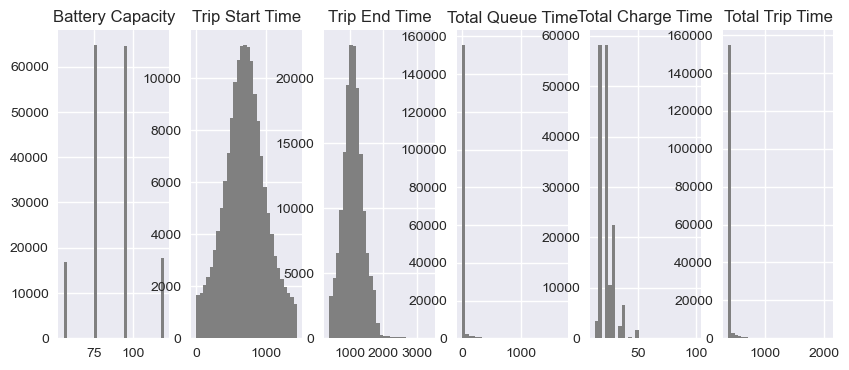

In [40]:
s4['driver_results_hist']

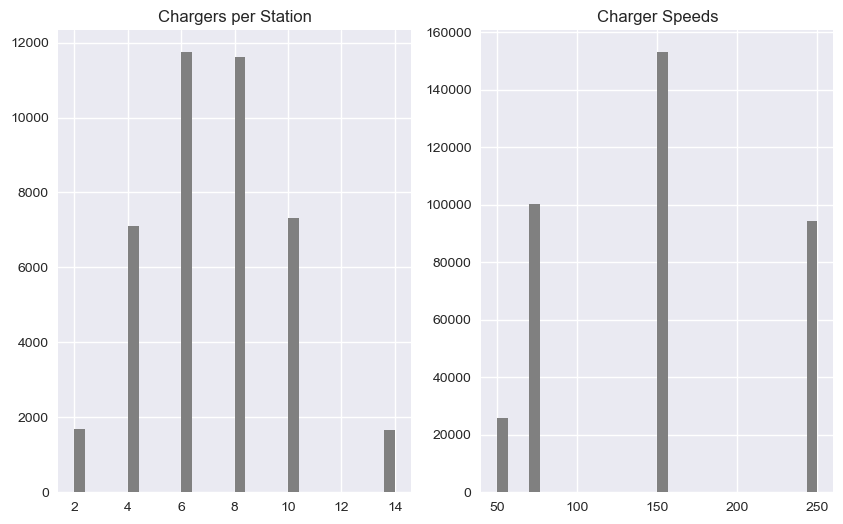

In [41]:
s4['station_metrics_hist']

In [51]:
s4.keys()

df = s4['driver_results']
df = df.drop(columns=['driver_id','mileage','model','trip_start_time','trip_end_time','epoch','mc_run'])
df.head()

,num_stations,battery_capacity,efficiency,battery_level_end,trip_time,queue_time,charge_time,station_time,charges,db
0,189,95,0.19,72.58,376.177559,0.0,22.7808,22.7808,1,0
1,189,75,0.18,22.44,371.233559,0.0,17.8368,17.8368,1,0
2,189,75,0.18,34.32,371.276759,0.0,17.8800,17.8800,1,0
3,189,95,0.19,69.54,376.143959,0.0,22.7472,22.7472,1,0
4,189,95,0.19,41.99,376.155959,0.0,22.7592,22.7592,1,0


In [61]:
correlations = df.corr()
correlations

,num_stations,battery_capacity,efficiency,battery_level_end,trip_time,queue_time,charge_time,station_time,charges,db
num_stations,1.000000,0.008456,0.008401,0.015962,-0.237009,-0.238390,0.026467,-0.237009,-0.011719,NaN
battery_capacity,0.008456,1.000000,0.997624,0.765099,0.021100,-0.003848,0.402590,0.021100,-0.520237,NaN
efficiency,0.008401,0.997624,1.000000,0.747589,0.022570,-0.001413,0.386990,0.022570,-0.543001,NaN
battery_level_end,0.015962,0.765099,0.747589,1.000000,0.001388,-0.033833,0.568881,0.001388,0.022496,NaN
trip_time,-0.237009,0.021100,0.022570,0.001388,1.000000,0.998082,0.013420,1.000000,-0.026029,NaN
queue_time,-0.238390,-0.003848,-0.001413,-0.033833,0.998082,1.000000,-0.048506,0.998082,-0.040791,NaN
charge_time,0.026467,0.402590,0.386990,0.568881,0.013420,-0.048506,1.000000,0.013420,0.238898,NaN
station_time,-0.237009,0.021100,0.022570,0.001388,1.000000,0.998082,0.013420,1.000000,-0.026029,NaN
charges,-0.011719,-0.520237,-0.543001,0.022496,-0.026029,-0.040791,0.238898,-0.026029,1.000000,NaN
db,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trip_time_factors = correlations['trip_time'].sort_values(ascending=False)
trip_time_factors

In [62]:
summary_stats = df.describe()
summary_stats

,num_stations,battery_capacity,efficiency,battery_level_end,trip_time,queue_time,charge_time,station_time,charges,db
count,163956.000000,163956.000000,163956.000000,163956.000000,163956.000000,163956.000000,163956.000000,163956.000000,163956.000000,163956.0
mean,274.229049,85.666124,0.185064,44.242759,393.780972,17.328050,23.056163,40.384213,1.080253,0.0
std,150.601814,17.412301,0.008195,24.354080,100.003961,100.112798,6.198071,100.003961,0.271686,0.0
min,15.000000,55.000000,0.170000,0.090000,365.963159,0.000000,12.566400,12.566400,1.000000,0.0
25%,135.000000,75.000000,0.180000,26.040000,371.372759,0.000000,17.966400,17.976000,1.000000,0.0
50%,302.000000,95.000000,0.190000,41.040000,376.146359,0.000000,22.720800,22.749600,1.000000,0.0
75%,418.000000,95.000000,0.190000,59.090000,382.100759,0.000000,26.208000,28.704000,1.000000,0.0
max,502.000000,120.000000,0.200000,116.800000,2081.391432,1710.114674,100.000000,1727.994674,2.000000,0.0


In [56]:
import seaborn as sns

Text(0.5, 1.0, 'Number of Stations vs Average Trip Time')

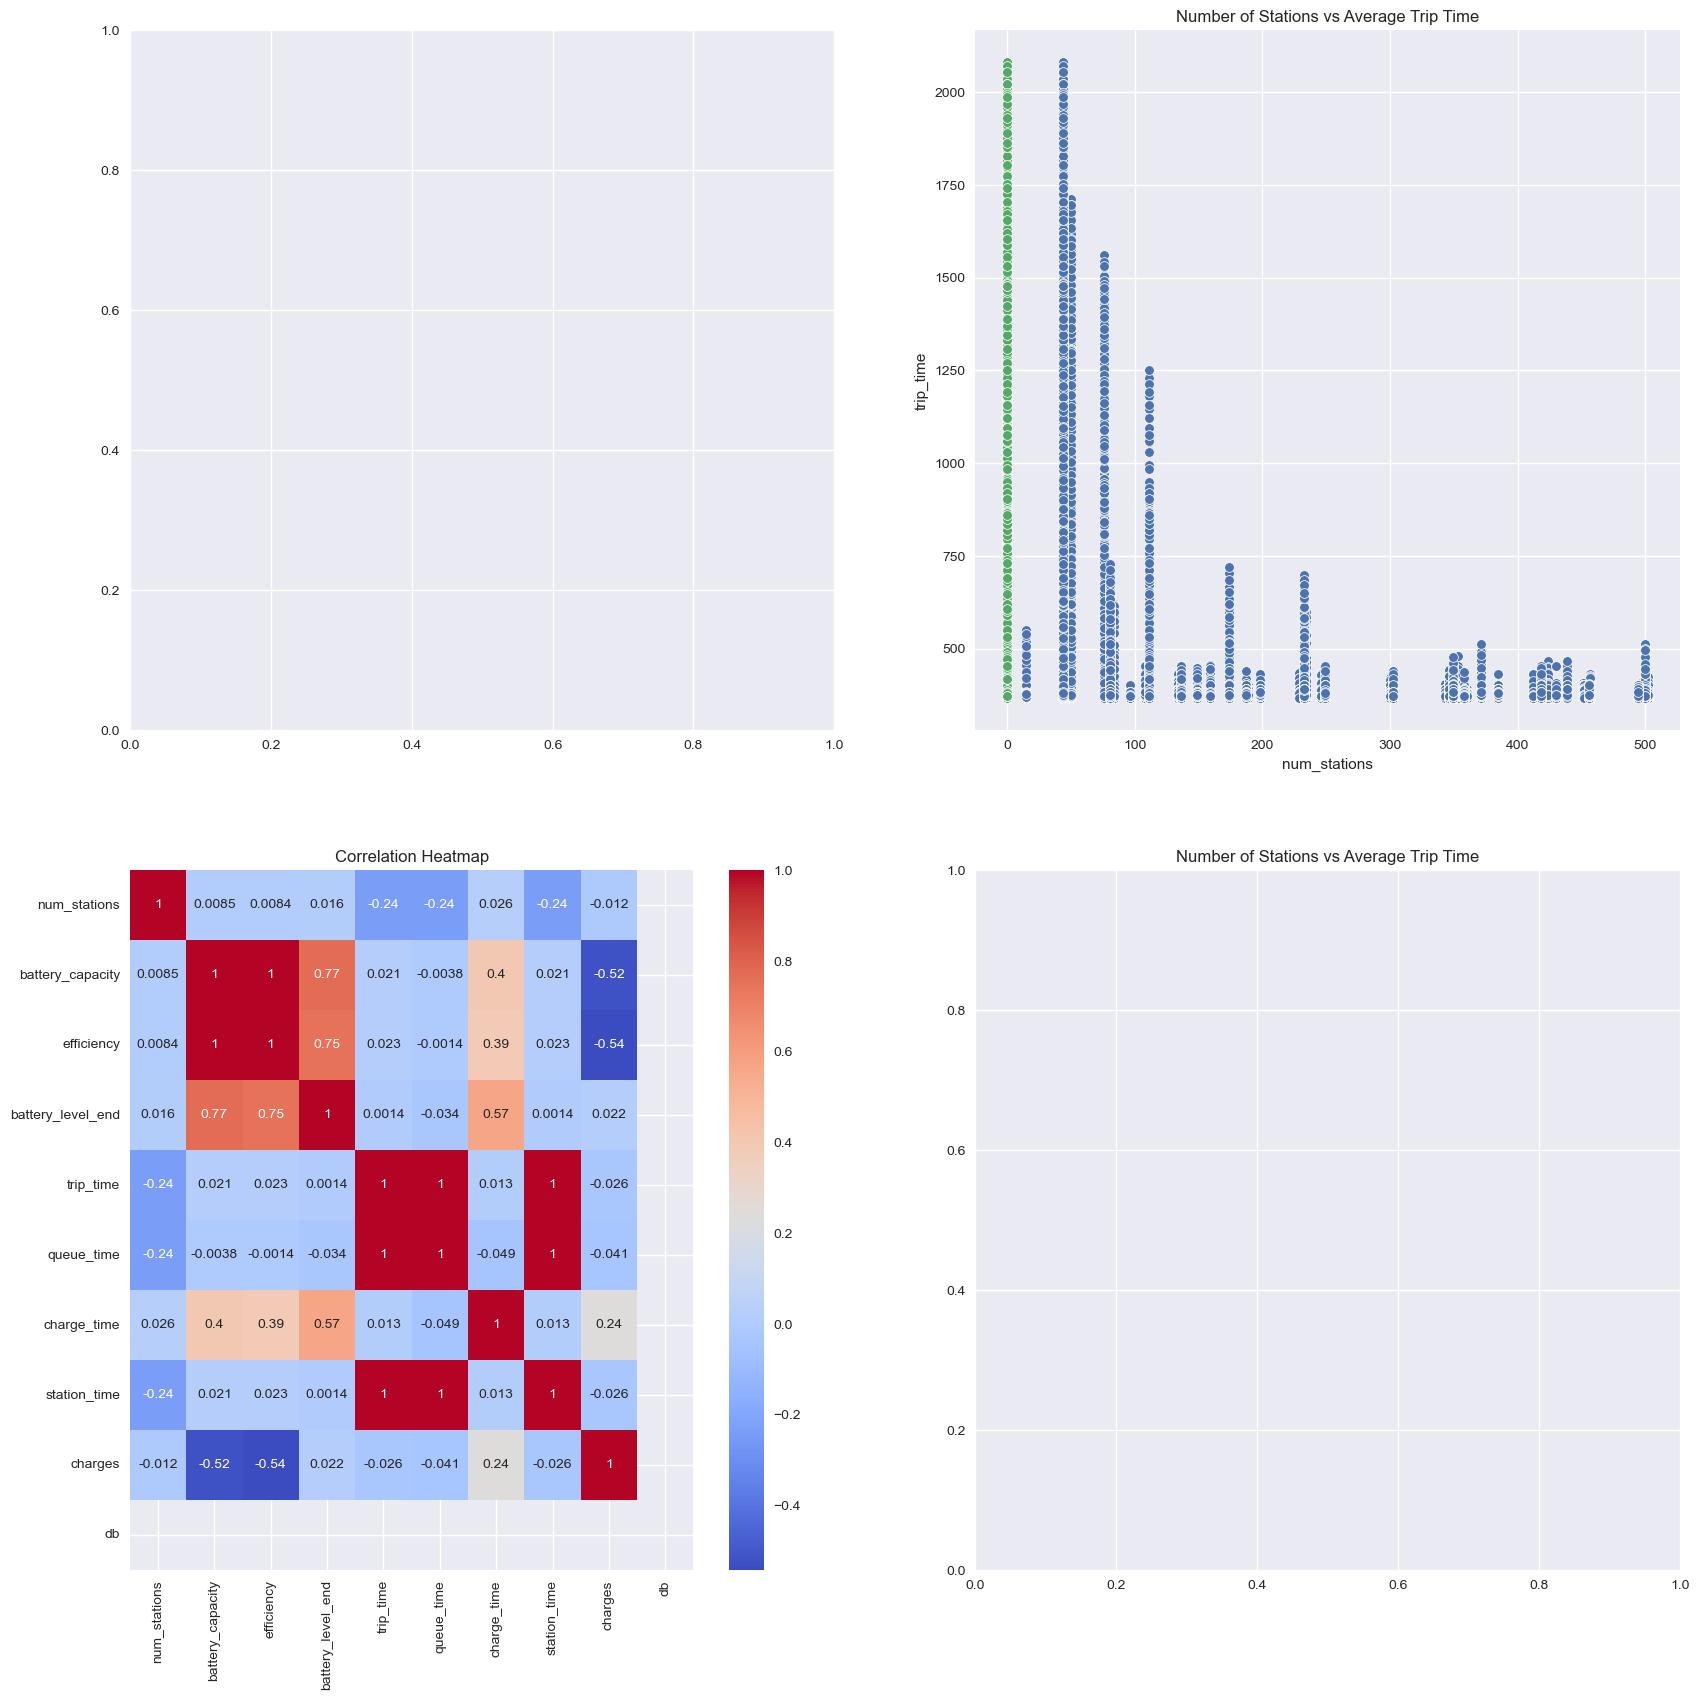

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

sns.heatmap(correlations, annot=True, cmap='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Correlation Heatmap')

sns.scatterplot(x='num_stations', y='trip_time', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Number of Stations vs Average Trip Time')

sns.scatterplot(x='efficiency', y='trip_time', data=df, ax=axes[0, 1])
axes[1, 1].set_title('Number of Stations vs Average Trip Time')
